# Math multiplications with qwen

In [6]:
from pathlib import Path

import matplotlib.pyplot as plt

from math_eval.config import load_model_registry
from math_eval.dataset_loader import load_tasks
from math_eval.model_loader import load_text_generation_pipeline
from math_eval.evaluator import MathEvaluator

DATA_DIR = Path('data/mult_taks')
RESULTS_DIR = Path('results/mult_task_base')
REGISTRY_PATH = Path('configs/models.yaml')
MODELS = [
    'qwen2.5-0.5b',
    'qwen2.5-1.5b',
]
BATCH_SIZE = 32
LIMIT = None

datasets = sorted(DATA_DIR.glob('*.jsonl'))
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print(f'Datasets: {[p.name for p in datasets]}')
print(f'Models: {MODELS}')
print(f'Batch size: {BATCH_SIZE}')


Datasets: ['results_sub_100.jsonl', 'results_sub_1_000_000.jsonl', 'results_sub_1_000_000_000_000.jsonl', 'resutls_sub_10_000.jsonl']
Models: ['qwen2.5-0.5b', 'qwen2.5-1.5b']
Batch size: 32


In [7]:
def write_report(path: Path, summary):
    failures = [r for r in summary['results'] if not r.is_correct]
    lines = [
        f'Dataset: {summary["dataset"]}',
        f'Total: {summary["total"]}',
        f'Correct: {summary["correct"]}',
        f'Accuracy: {summary["accuracy"]*100:.1f}%',
        '',
        'Failed cases:' if failures else 'All cases correct.',
    ]
    for rec in failures:
        lines.append(f"- {rec.task_id}: expected '{rec.reference_answer}', predicted '{rec.extracted_answer}'")
        lines.append(f'  question: {rec.question}')
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text('\n'.join(lines))


def evaluate_model(model_key: str, dataset_paths, batch_size: int):
    registry = load_model_registry(REGISTRY_PATH)
    if model_key not in registry:
        raise ValueError(f'Model {model_key} not found in registry')
    cfg = registry[model_key]
    text_pipe, gen_kwargs = load_text_generation_pipeline(cfg)
    evaluator = MathEvaluator(text_pipe, gen_kwargs, batch_size=batch_size)
    summaries = []
    for ds_path in dataset_paths:
        tasks = load_tasks(ds_path, limit=LIMIT)
        summary = evaluator.run(tasks)
        summary['dataset'] = ds_path.name
        summaries.append(summary)

        jsonl_out = RESULTS_DIR / f"{ds_path.stem}__{model_key}.jsonl"
        MathEvaluator.write_results(jsonl_out, summary['results'])
        report_out = RESULTS_DIR / f"{ds_path.stem}__{model_key}.txt"
        write_report(report_out, summary)
    return summaries


In [8]:
all_summaries = {}
for model_key in MODELS:
    print(f'\nEvaluating {model_key} with batch size {BATCH_SIZE}...')
    all_summaries[model_key] = evaluate_model(model_key, datasets, batch_size=BATCH_SIZE)
print('\nDone.')



Evaluating qwen2.5-0.5b with batch size 32...


Device set to use cuda:0
Evaluating:  64%|██████▍   | 64/100 [00:08<00:06,  5.45it/s, acc=0/64]    You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Evaluating qwen2.5-1.5b with batch size 32...


Device set to use cuda:0
                                                                          


Done.


In [9]:
accuracy_rows = []
for model_key, summaries in all_summaries.items():
    for summary in summaries:
        accuracy_rows.append((summary['dataset'], model_key, summary['accuracy'] * 100))

if not accuracy_rows:
    print('No accuracy data. Run the previous cell first.')
else:
    for ds, model_key, acc in accuracy_rows:
        print(f'{ds:32s} {model_key:18s} {acc:.1f}%')


results_sub_100.jsonl            qwen2.5-0.5b       100.0%
results_sub_1_000_000.jsonl      qwen2.5-0.5b       8.0%
results_sub_1_000_000_000_000.jsonl qwen2.5-0.5b       0.0%
resutls_sub_10_000.jsonl         qwen2.5-0.5b       62.0%
results_sub_100.jsonl            qwen2.5-1.5b       100.0%
results_sub_1_000_000.jsonl      qwen2.5-1.5b       38.0%
results_sub_1_000_000_000_000.jsonl qwen2.5-1.5b       1.0%
resutls_sub_10_000.jsonl         qwen2.5-1.5b       92.0%


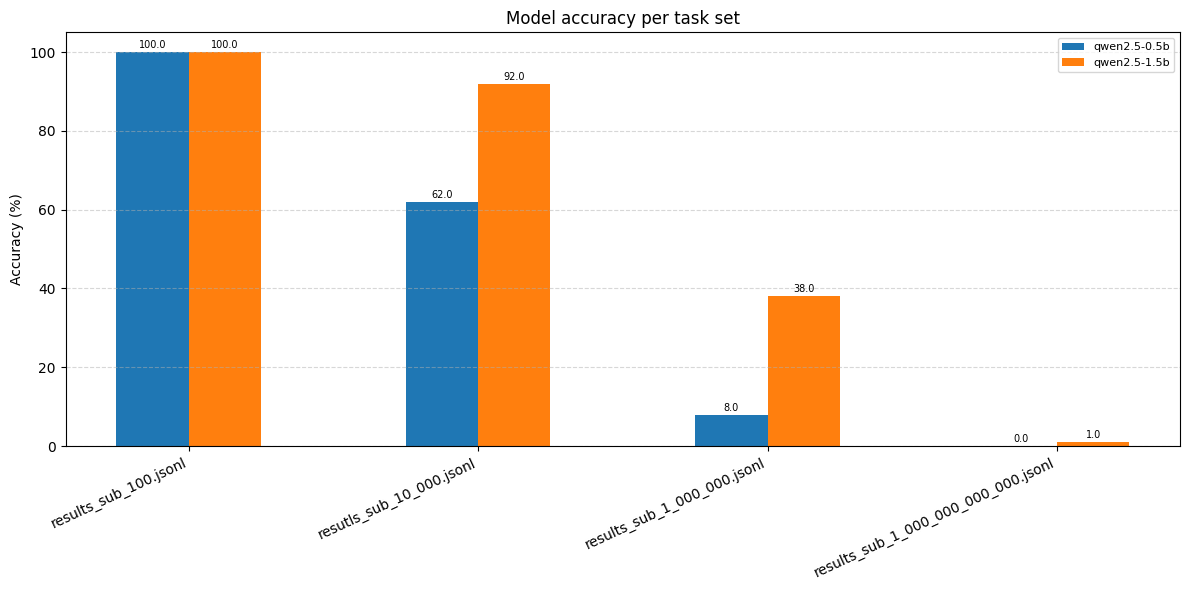

In [13]:
import re

def _parse_size(name: str) -> int:
    matches = re.findall(r'(\d[\d_]*)', name)
    if not matches:
        return 0
    try:
        return int(matches[-1].replace('_', ''))
    except ValueError:
        return 0

if not accuracy_rows:
    print('No data to plot. Run evaluations first.')
else:
    dataset_names = sorted({row[0] for row in accuracy_rows}, key=_parse_size)
    model_names = MODELS
    bar_width = 0.25  # much thinner bars
    indices = list(range(len(dataset_names)))

    plt.figure(figsize=(12, 6))
    for i, model_key in enumerate(model_names):
        positions = [idx + (i - (len(model_names) - 1) / 2) * bar_width for idx in indices]
        accs = []
        for ds in dataset_names:
            match = next((row[2] for row in accuracy_rows if row[0] == ds and row[1] == model_key), 0.0)
            accs.append(match)
        bars = plt.bar(positions, accs, width=bar_width, label=model_key)
        for bar, acc in zip(bars, accs):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.5,
                f"{acc:.1f}",
                ha='center',
                va='bottom',
                fontsize=7,
            )

    plt.xticks(indices, dataset_names, rotation=25, ha='right')
    plt.ylabel('Accuracy (%)')
    plt.title('Model accuracy per task set')
    plt.legend(fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
